In [1]:
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('chesterish')

In [2]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines, numpy as np, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import root_pandas,glob

import gc

import uproot
def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='images'

import misc_util#correlation_plots

import R2h_module
import imp
imp.reload(R2h_module)

import mplhep as hep
hep.style.use("CMS")

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [4]:
#sets =  "D_C C D_Fe Fe Pb D_Pb".split()
#sets += "MC_D2 MC_C MC_Fe MC_Pb".split()
#sets += "no_ecuts_D_C no_ecuts_C no_ecuts_D_Fe no_ecuts_Fe no_ecuts_Pb no_ecuts_D_Pb".split()
#sets += "xQ2_D_C xQ2_C xQ2_D_Fe xQ2_Fe xQ2_Pb xQ2_D_Pb".split()

#dfs_mixed = {a : root_pandas.read_root("../../eg2/python/mixed_%s.root"%a)  for a in sets}

mixtag='xQ2_'
#mixtag='xQ2_originalK_'
dfs_mixed = {a : root_pandas.read_root(f"/data/sebouh/eg2/python/mixed_{mixtag}{a}.root")  for a in "D_C D_Fe D_Pb".split()}
#dfs_mixed = {a : root_pandas.read_root(f"/home/sebouh/eg2/python/mixed_{mixtag}{a}.root")  for a in "D_C C D_Fe Fe Pb D_Pb".split()}

In [5]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df

In [6]:
%%time
dfs_pair = {}
dfs_trigger = {}
#path_data="/home/sebouh/di-hadron"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    dfs_pair['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    dfs_trigger['D_%s'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 2.63 s, sys: 13.8 ms, total: 2.64 s
Wall time: 2.64 s


In [7]:
for dct in dfs_mixed,dfs_pair, dfs_trigger:
    print(dct.keys())
    dct['D'] = pd.concat([dct['D_'+a] for a in 'C Fe Pb'.split()])

dict_keys(['D_C', 'D_Fe', 'D_Pb'])
dict_keys(['D_C', 'D_Fe', 'D_Pb'])
dict_keys(['D_C', 'D_Fe', 'D_Pb'])


<ipython-input-7-2bd486f10182>:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  dct['D'] = pd.concat([dct['D_'+a] for a in 'C Fe Pb'.split()])


In [8]:
%%time
import R2h_module as r2h

for key in dfs_pair.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    dfs_pair[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_pair[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    dfs_pair[key] = r2h.applyCuts(dfs_pair[key],isMC=isMC, nomCuts=True)
    dfs_pair[key] = r2h.applyCutsPair(dfs_pair[key],isMC=isMC, nomCuts=True)


key:  D_C
Entries before cut  185530
Q2>1.0 and Q2<4.0 185530  (100.00  %)
0.2<h1_p<5.0  185525  (100.00  %)
inelasticity < 0.85 185525  (100.00  %)
h1_pid = pions (trigger) 185525  (100.00  %)
2.2 < nu <4.2 182357  (98.29  %)
10< h1_th 182357  (100.00  %)
Theta/P fiducial region selected for trigger hadron 182357  (100.00  %)
Nom cuts for the trigger applied 67923  (37.25  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 67923  (100.00  %)
2.2 < nu < 4.2 67923  (100.00  %)
secondary hadrons are pions 67923  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 57422  (84.54  %)
kinematic limits for h2_z 57293  (99.78  %)
kinematic limits for dphi 57233  (99.90  %)
kinematic limits for pair_mass 57108  (99.78  %)
leading hadrons are pions 57108  (100.00  %)
0.2<h2_p<5.0 57108  (100.00  %)
0.2<h1_p<5.0 57108  (100.00  %)
10<h2_th 57108  (100.00  %)
Theta/P fiducial region selected for secondary hadron 52003  (91.06  %)
10< h1_th 52003  (100.00  %)
Theta/P fiducial regi

In [9]:
for key in dfs_trigger.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True    
    print (key, isMC)
    dfs_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_trigger[key] = r2h.applyCuts(dfs_trigger[key],isTrigger=True, isMC=isMC, nomCuts=True)
    print (' ')
    

D_C False
Entries before cut  875478
Q2>1.0 and Q2<4.0 875478  (100.00  %)
0.2<h1_p<5.0  875467  (100.00  %)
inelasticity < 0.85 875467  (100.00  %)
h1_pid = pions (trigger) 875467  (100.00  %)
2.2 < nu <4.2 863117  (98.59  %)
10< h1_th 863117  (100.00  %)
Theta/P fiducial region selected for trigger hadron 863117  (100.00  %)
Nom cuts for the trigger applied 405810  (47.02  %)
 
D_Fe False
Entries before cut  667932
Q2>1.0 and Q2<4.0 667932  (100.00  %)
0.2<h1_p<5.0  667932  (100.00  %)
inelasticity < 0.85 667932  (100.00  %)
h1_pid = pions (trigger) 667932  (100.00  %)
2.2 < nu <4.2 667932  (100.00  %)
10< h1_th 667932  (100.00  %)
Theta/P fiducial region selected for trigger hadron 667932  (100.00  %)
Nom cuts for the trigger applied 667932  (100.00  %)
 
D_Pb False
Entries before cut  1352263
Q2>1.0 and Q2<4.0 1352263  (100.00  %)
0.2<h1_p<5.0  1352241  (100.00  %)
inelasticity < 0.85 1352241  (100.00  %)
h1_pid = pions (trigger) 1352241  (100.00  %)
2.2 < nu <4.2 1334308  (98.67  

In [10]:
import R2h_module
import imp
imp.reload(R2h_module)
for key in list(dfs_mixed.keys()):
    isMC=False
    if 'GiBUU' in key:
        isMC=True
    dfs_mixed[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_mixed[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    
    print(f"\n\n{key}")
    if  'dphi' not in dfs_mixed[key].columns:
        dfs_mixed[key].eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
        dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm-{2*np.pi}*(diff_phi_cm>{np.pi})', inplace=True)
        dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm+{2*np.pi}*(diff_phi_cm<{-np.pi})', inplace=True)
        dfs_mixed[key].eval(f'dphi = abs(diff_phi_cm)', inplace=True)
    dfs_mixed[key].eval('h1_e=nu*h1_z',inplace=True)
    dfs_mixed[key].eval('h2_e=nu*h2_z',inplace=True)
    dfs_mixed[key].eval(f'drap=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)

    mixed_trigger_cuts = dfs_mixed[key]#R2h_module.applyCuts(dfs_mixed[key])    
    dfs_mixed[key] = R2h_module.applyCutsPair(mixed_trigger_cuts,isMC=isMC,
                                                             nomCuts=True,h2Proton=False, minPt=np.sqrt(0.005))
    
    #for df in (dfs_data[key + '_2pi'],dfs_data[key + '_pi_p']):
    #    df.eval('diff_rap_cm=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)
    #    df.eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
    #    df.eval(f'diff_phi_cm = diff_phi_cm-{2*np.pi}*(diff_phi_cm>{np.pi})', inplace=True)
    #    df.eval(f'diff_phi_cm = diff_phi_cm+{2*np.pi}*(diff_phi_cm<{-np.pi})', inplace=True)



D_C
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 3403326  (100.00  %)
2.2 < nu < 4.2 3361656  (98.78  %)
secondary hadrons are pions 2449421  (72.86  %)
(h1_pid*h2_pid)<0, opposite charge pions 930584  (37.99  %)
kinematic limits for h2_z 899056  (96.61  %)
kinematic limits for dphi 898616  (99.95  %)
kinematic limits for pair_mass 890515  (99.10  %)
leading hadrons are pions 890515  (100.00  %)
0.2<h2_p<5.0 890515  (100.00  %)
0.2<h1_p<5.0 890515  (100.00  %)
pt>0.07071067811865475 GeV 866977  (97.36  %)
10<h2_th 866977  (100.00  %)
Theta/P fiducial region selected for secondary hadron 816153  (94.14  %)
10< h1_th 816153  (100.00  %)
Theta/P fiducial region selected for trigger hadron 816153  (100.00  %)
Nom cuts for the pair applied (pi pi) 339912  (41.65  %)


D_Fe
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 3475129  (100.00  %)
2.2 < nu < 4.2 3436999  (98.90  %)
secondary hadrons are pions 2522944  (73.41  %)
(h1_pid*h2_pid)<0, opposite char

In [11]:
#dfs_mc= {f"{a}_2pi":root_pandas.read_root(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_{a}.root",a) for a in "C Fe Pb".split()}
#dfs_mc["D_2pi"] = root_pandas.read_root(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_C.root","D_C")

In [14]:
# additional cuts that were not applied to the GiBUU set in PRL,
# but we should see what happens if we include them.  
pThetaCuts_trig=' ((h1_pid==211 and h1_th>10) or (h1_pid==-211) and ((h1_th>25 and h1_p>0.7) or (h1_p>0.5 & h1_th>30) or (h1_th>40)))'

#pThetaCuts_trig+=" and h1_th>20 and h1_p<2.7"

pThetaCuts_pair=pThetaCuts_trig 
pThetaCuts_pair += " and " + pThetaCuts_trig.replace("h1_", "h2_").replace("h2_th", "h2_th*180/3.1415926535")



In [16]:
def get_values(slicevar='drap', slicevartex='\Delta Y', slicebins=(-1,0,1,2,3), 
               dropLeadPiMinus=True, usePRLcuts=False, saveFig=False,
              pThetaCutsGiBUU=True, pMin=.350, pT1min=.25, pT2min=.25,
               suptitle=None,nbins_data=8, nbins_GiBUU=16, GiBUU_suffix="",
              addCuts=None, addCutsTrig=None):
    #unbinned.
    if slicevar is None:
        slicebins=[0,1]
    
    pids = [211, -211]
    
    data=[]
    GiBUU=[]
    sliceinfo={}
    
    #guess for the systematic errors from sources not inves
    systPct=3
    pid=211
    
    for k in range(len(slicebins)-1):
        data.append({})
        GiBUU.append({})
        slice_range=slicebins[k:k+2]

        integral_data_D = 0
        data_D=None
        stat_D=None
        Alist = enumerate("D_C D_Fe D_Pb".split())
        for i, A in Alist:

            

            q = f"h1_pid=={pid}  and h2_z>0.05 and h2_z<0.45 and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid=={-pid} and h2_p>{pMin}"
            #q += " and h1_p<2.7"
            #q+= " and h1_p<2.7 and h2_p>0.5 and h1_cm_pt>0.3 and h2_cm_pt>0.3"
            if usePRLcuts:
                #the dtheta_epi1 cut is a useless one, but we used it in the PRL paper,
                #so we need this in order to make the comparison
                q = "dtheta_epi1>25 and h2_z>0.05 and h2_z<0.45 and " + PRL_trigger_cut_nom + PRL_pair_cut_nom 

            if slicevar != None:
                q+= f" and {slicevar}>={slice_range[0]} and {slicevar}<{slice_range[1]}"
            
            if addCuts is not None:
                q+= f" and {addCuts}"

            which_set = "D_Pb" if A=="D" and usePRLcuts else A
            #which_set=A

            bins = np.linspace(0,np.pi if not usePRLcuts else 3.14,nbins_data+1)

            N2, x = np.histogram(dfs_pair[which_set].query(q)['dphi'], bins=bins)
            if usePRLcuts:
                q = "h2_z>0.05 and h1_z>0.5"
            N2mix, x = np.histogram(dfs_mixed["D" if usePRLcuts else A].query(q)['dphi'], bins=bins)

            #M_alt = mix_corr_alt(dfs_mixed[A].query(q))
            
            qtrig = f"h1_pid=={pid} and  h1_cm_pt > {pT1min}"
            if usePRLcuts:
                qtrig = "dtheta_epi1>25 and " + PRL_trigger_cut_nom

            if addCutsTrig is not None:
                qtrig += f" and {addCutsTrig}"
            
            N1 = len(dfs_trigger[which_set].query(qtrig))

            x = (x[1:]+x[:-1])/2
            dx = x[1]-x[0]

            S = N2/dx/N1/2
            dSstat = np.sqrt(N2*(N1-N2)/N1**3)/dx/2

            M = N2mix/(sum(N2mix)/len(N2mix))
            dMstat = np.sqrt(N2mix)/(sum(N2mix)/len(N2mix))

            M_err = np.sqrt(np.mean((M-1)**2))/2
            #print((A,pid,k),"estimated syst error from event mixing",  M_err)

            C = S/M
            dCstat = dSstat/M
            
            


            if A=="D" or "D_" in A:  
                integral_data_D=sum(C)*dx*2

            dCsyst = np.hypot(C*systPct/100, C*dMstat)
            C/=integral_data_D
            dCstat/=integral_data_D
            dCsyst/=integral_data_D

            if A=='D' or "D_" in A:
                data_D=C
                stat_D=dCstat

            R_data = C/data_D
            dR_data_stat = C/data_D*np.hypot(dCstat/C, stat_D/data_D)
            dCtot = np.hypot(dCstat, dCsyst)

            
            data[k][A] = pd.DataFrame(dict(C=C, dCstat=dCstat, dCsyst=dCsyst, 
                                            phi=x,phi_low=bins[:-1], phi_up=bins[1:],
                                                S=S, M=M, dSstat=dSstat, dMstat=dMstat,
                                                R=R_data,
                                                dRstat=dR_data_stat))
            if "D_" in A:
                continue

            #GiBUU
            # do the GiBUU twice: once with the same number of bins as the data,
            # and then with a finer binning
        
#         for useFinerBinning in False, True:
#             integral_GiBUU_D = 0
#             GiBUU_D=None
#             for i, A in enumerate("D C Fe Pb".split()):
            
#                 nbins = nbins_data if not useFinerBinning else nbins_GiBUU
#                 bins = np.linspace(0,np.pi if not usePRLcuts else 3.14,nbins+1)
#                 q = f"h1_pid=={pid} and h1_z>0.5  and h2_z>0.05 and h2_z<0.45 and h1_cm_pt > {pT1min} and h2_cm_pt > {pT2min} and h2_pid=={-pid}"
#                 if usePRLcuts:
#                     q = "h2_z>0.05 and h1_z>0.5 and h2_z<0.45"
#                 if slicevar != None:
#                     q+= f" and {slicevar}>={slice_range[0]} and {slicevar}<{slice_range[1]}"
#                 if pThetaCutsGiBUU:
#                     q += " and " + pThetaCuts_pair + f" and h2_p>{pMin}"


#                 N2, x = np.histogram(dfs_pair[f"GiBUU_{A}"+GiBUU_suffix].query(q)['dphi'], bins=bins)

#                 x = (x[1:]+x[:-1])/2
#                 dx =x[1]-x[0]

#                 qtrig = f"h1_pid=={pid}  and h1_z>0.5 "
#                 if usePRLcuts:
#                     qtrig = "h1_pid==h1_pid"
#                 if pThetaCutsGiBUU:
#                     qtrig += " and " + pThetaCuts_trig + f" and  h1_cm_pt > {pT1min}"
#                 N1 = len(dfs_trigger["GiBUU_"+A+GiBUU_suffix].query(qtrig))
#                 y = N2/N1/dx/2
#                 #print(N1, N2)
#                 if A=="D":
#                     integral_GiBUU_D=sum(y)*dx*2

#                 y/=integral_GiBUU_D

#                 if A=="D" or "D_" in A:
#                     GiBUU_D = pd.Series(y)
#                 R_GiBUU = y/GiBUU_D

#                 tmp = A + "_fine" if useFinerBinning else A
#                 GiBUU[k][tmp] = pd.DataFrame(dict(C=y, R=y/GiBUU_D,
#                                                 phi=x, 
#                                                  phi_low=bins[:-1], phi_up=bins[1:]))
            
            

        if slicevar is not None:
            sliceinfo[k] = f"{slice_range[0]:.2f} < ${slicevartex}$< {slice_range[1]:.2f}"
        else :
            sliceinfo[k] = f""
                
    return data, GiBUU, sliceinfo

In [17]:
all_data_uncorr={}
all_data={}
all_GiBUU={}
all_sliceinfo={}

In [18]:
data, GiBUU, sliceinfo = get_values(None,  pThetaCutsGiBUU=True,GiBUU_suffix='_tweak_harut')


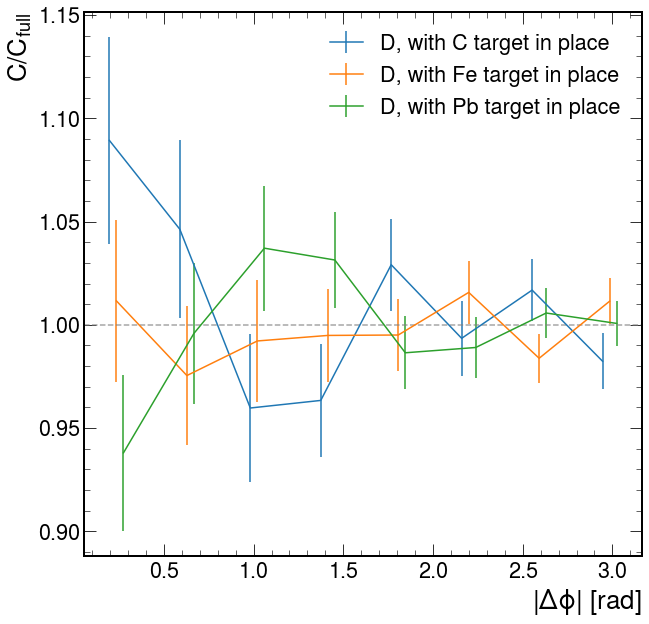

24.41708344363587 16 0.0807824758099221


In [31]:
num=0
denom=0
for a in "C Fe Pb".split():
    C=data[0][f'D_{a}']['C']
    dCstat=data[0][f'D_{a}']['dCstat']
    num=num+C/dCstat**2
    denom=denom+1/dCstat**2
wavg=num/denom
from scipy.stats import chi2
chi2tot=0
ndof = -len(wavg)
shift=0
for a in "C Fe Pb".split():
    x=data[0][f'D_{a}']['phi']
    C=data[0][f'D_{a}']['C']
    dCstat=data[0][f'D_{a}']['dCstat']
    plt.errorbar(x+shift, C/wavg, dCstat/wavg, label=f'D, with {a} target in place')
    chi2tot+=sum((C-wavg)**2/dCstat**2)
    ndof+=len(C)
    shift+=np.pi/len(C)/10
plt.axhline(1, color='0.5', alpha=0.7, linestyle='--')
plt.xlabel("$|\Delta\phi|$ [rad]")
plt.ylabel("$C/C_{\\rm full }$")
plt.legend()
plt.show()
print(chi2tot,ndof, chi2.sf(chi2tot, ndof))